In [ ]:
# Center Points Generation: Sampling weighted random distribution

In [1]:
%matplotlib inline

import sys
import numba
#import matlab.engine
import numpy as np
import scipy as sp
import scipy.stats as st
import sympy as sym
import numexpr as ne
from ipywidgets import interact
from math import sqrt, log, floor, ceil
import matplotlib.pyplot as plt
from scipy import interpolate, optimize
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

# acalib helper functions
sys.path.append('../../ACALIB/')
import acalib
from acalib import load_fits, standarize

# extra metric module
import custom_metric as cm

In [2]:
def points_plot(data, center_points=None, collocation_points=None, boundary_points=None):
    if (center_points is not None) and (collocation_points is None):
        plt.figure(figsize=(8,8))
        plt.imshow(data)
        plt.scatter(center_points[:,0]*99, center_points[:,1]*99, c='r', s=5, label='center')
        plt.title('Center points')
        plt.axis('off')
    elif (center_points is None) and (collocation_points is not None):
        plt.figure(figsize=(8,8))
        plt.imshow(data)
        plt.scatter(collocation_points[:,0]*99, collocation_points[:,1]*99, c='g', s=5, label='collocation')
        plt.title('Collocation points')
        plt.axis('off')
    elif (center_points is not None) and (collocation_points is not None):
        fig = plt.figure(figsize=(20,15))
        ax1 = fig.add_subplot(121)
        ax1.imshow(data)
        ax1.scatter(center_points[:,0]*99, center_points[:,1]*99, c='r', s=5, label='center')
        ax1.set_title('Center points')
        ax1.axis('off')
        ax2 = fig.add_subplot(122)
        ax2.imshow(data)
        ax2.scatter(collocation_points[:,0]*99, collocation_points[:,1]*99, c='g', s=5, label='collocation')
        ax2.set_title('Collocation points')
        ax2.axis('off')
    if (boundary_points is not None) and len(boundary_points[:,0])!=0:
        plt.figure(figsize=(8,8))
        plt.imshow(data)
        plt.scatter(boundary_points[:,0]*99, boundary_points[:,1]*99, c='y', s=5, label="boundary")
        plt.axis('off')
    #plt.colorbar(im, cax=cax)
    #fig.legend(bbox_to_anchor=(1.2, 1.0))
    plt.show()

## Loading 2D Data

In [3]:
"""
Loading data
"""

#fit_path = '../../bindata/fits/cubes/Antennae_North.CO3_2Line.Clean.pcal1.image.fits'
#fit_path = '../../bindata/fits/cubes/Antennae_South.CO3_2Line.Clean.pcal1.image.fits'
#fit_path = '../../bindata/fits/cubes/CenA.CO2_1Line.Clean.image.fits'
#fit_path = '../../bindata/fits/cubes/M100line.image.fits'
fit_path = '../../ACALIB/bindata/fits/cubes/Orion.methanol.cbc.contsub.image.fits'
#fit_path = '../../bindata/fits/cubes/ALMA01000740.fits'
container = load_fits(fit_path)
data = standarize(container.primary)[0]
data = data.data

#stacking it
data = data.sum(axis=0)
data -= data.min()
data /= data.max()

INFO: Processing HDU 0 (Image) [acalib.io.fits]
INFO: 4D data detected: assuming RA-DEC-FREQ-STOKES (like CASA-generated ones), and dropping STOKES [acalib.io.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


In [4]:
"""
Generating the data function
"""
x = np.linspace(0., 1., data.shape[0]+2, endpoint=True)[1:-1]
y = np.linspace(0., 1., data.shape[1]+2, endpoint=True)[1:-1]
dfunc = sp.interpolate.interp2d(x, y, data, kind='linear')

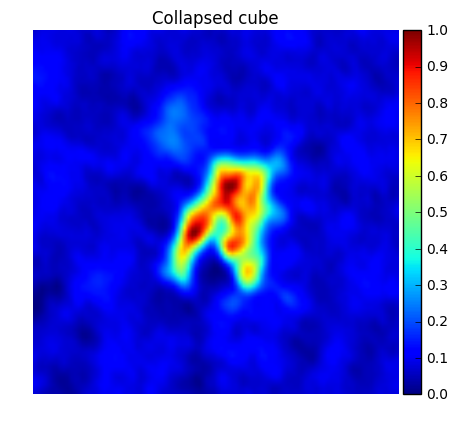

In [5]:
plt.figure(figsize=(5,5))
im = plt.imshow(data)
plt.title('Collapsed cube')
plt.axis('off')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

## Uniform 1D weighted distribution

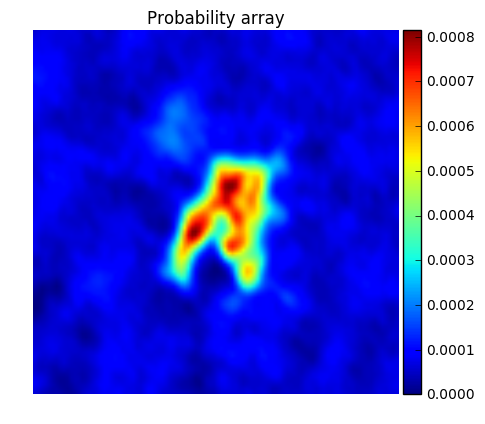

In [6]:
plt.figure(figsize=(5,5))
im = plt.imshow(data/data.sum())
plt.title('Probability array')
plt.axis('off')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

#### Approach 1: Sampling without modifying probabilities array

In [50]:
def inv_gaussian_kernel(kernlen=3, sig=0.1):
    """
    Returns a 2D Gaussian kernel array.
    """
    interval = (2*sig+1.)/(kernlen)
    x = np.linspace(-sig-interval/2., sig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel.max()-kernel

def random_centers_selection(data, n_centers, threshold=False, cut_value=None, power=5.):
    data = np.copy(data)
    mask = data <= cut_value
    data **= power
    # fixed seed
    np.random.seed(0)
    # data dimensions
    m,n = data.shape
    
    # center points positions
    x = np.linspace(0., 1., data.shape[0]+2, endpoint=True)[1:-1]
    y = np.linspace(0., 1., data.shape[1]+2, endpoint=True)[1:-1]
    X,Y  = np.meshgrid(x,y)
    points_positions = np.vstack( [ X.ravel(), Y.ravel() ]).T
    
    # array with indexes of such centers
    points_indexes = np.arange(0,points_positions.shape[0])
    
    # array with probabilities of selection for each center
    #prob = np.zeros(m+2, n+2)
    #prob[1:m+1, 1:n+1] = (data/data.sum())
    if threshold:
        data[mask] = 0.
        prob = data/data.sum()
    else:
        prob = data/data.sum()
    
    # convolution kernel
    #K = np.array([[0.5, 0.5, 0.5], [0.5, 0., 0.5], [0.5, 0.5, 0.5]])
    K = inv_gaussian_kernel(kernlen=3, sig=3.)
    
    selected = []
    while len(selected)!=n_centers:
        sel = np.random.choice(points_indexes, size=1 , p=prob.ravel(), replace=False)[0]
        # border pixels can't be selected
        index0 = sel / m
        index1 = sel % n
        if index0==0 or index0==m-1 or index1==0 or index1==n-1: continue
        selected.append(sel)
        # update the pixel probabilities array
        prob[index0-1:index0+2, index1-1:index1+2] *= K
        prob /= prob.sum()
        
    return points_positions[selected]

In [51]:
print(inv_gaussian_kernel(kernlen=3, sig=3.))

[[ 0.33994578  0.25868174  0.33994578]
 [ 0.25868174  0.          0.25868174]
 [ 0.33994578  0.25868174  0.33994578]]


In [52]:
cut_value = acalib.rms(data)/2

In [53]:
center_points = random_centers_selection(data, 1000, threshold=True, cut_value=cut_value)

In [54]:
extra_points = random_centers_selection(1-data, 500, threshold=True, cut_value=1-cut_value)

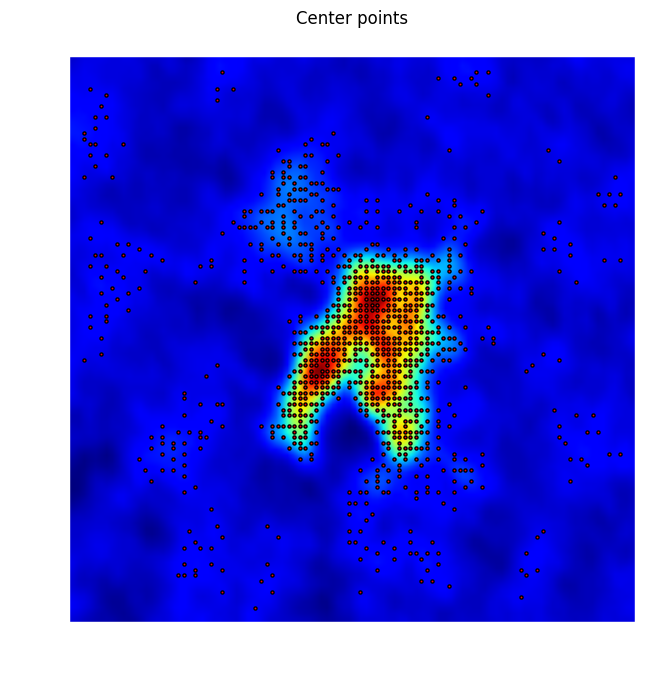

In [55]:
points_plot(data, center_points=center_points)

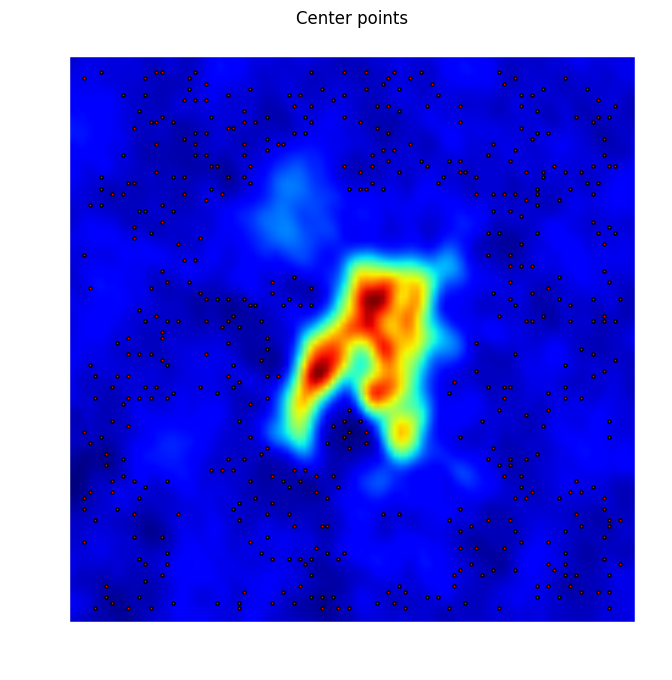

In [56]:
points_plot(data, center_points=extra_points)

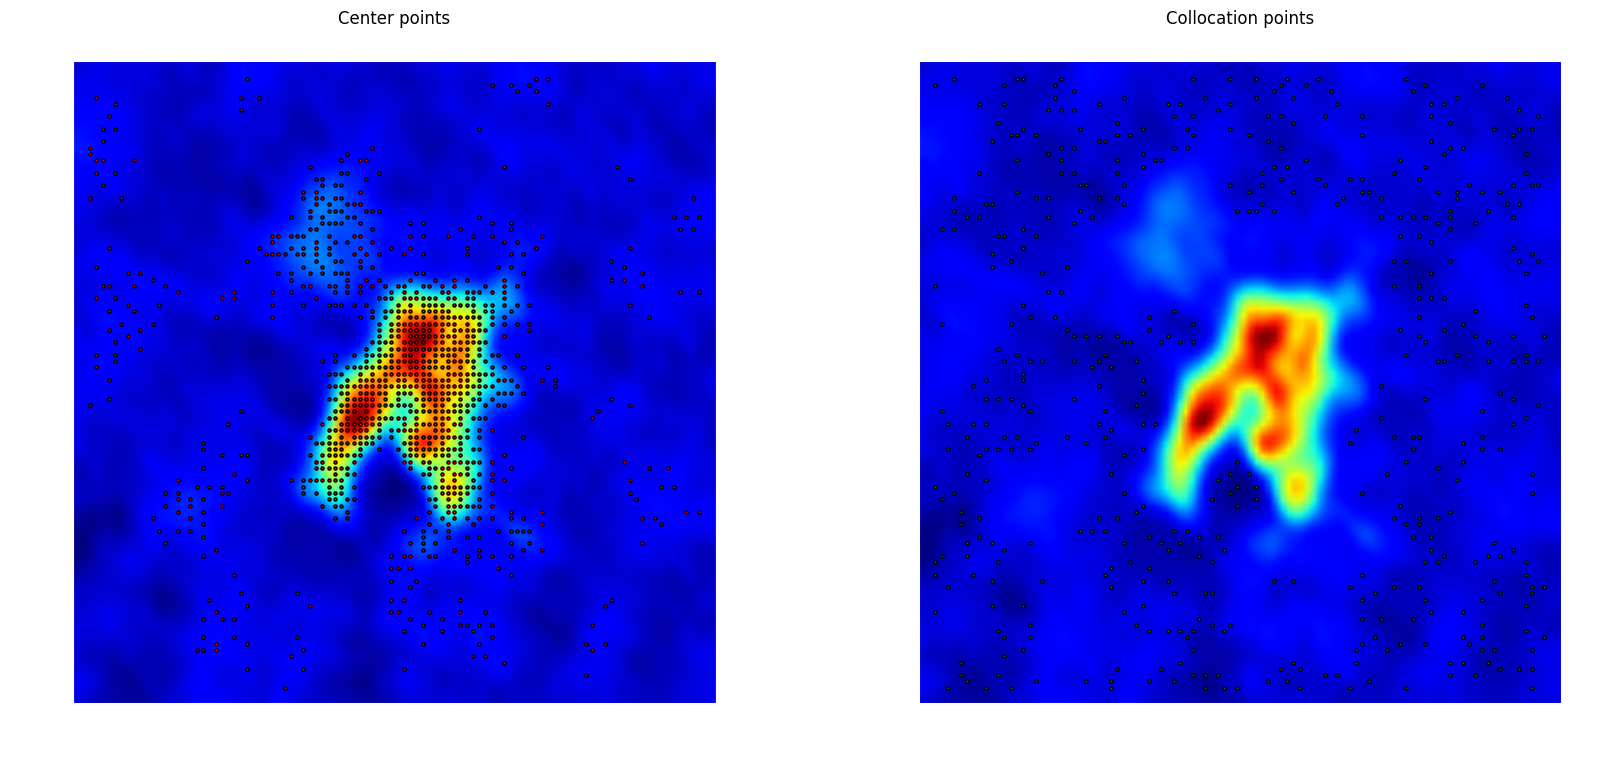

In [57]:
points_plot(data, center_points=center_points, collocation_points=extra_points)

### Effect of: `data **= power` with `data` $\in [0,1]$

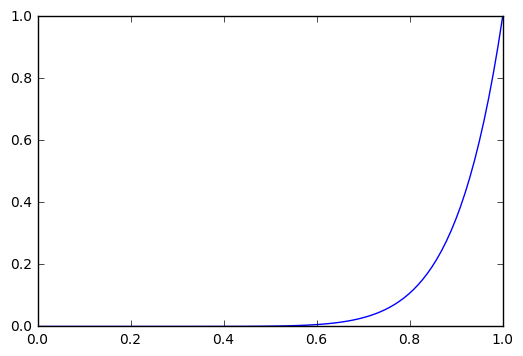

In [64]:
power = 10.
x_grid = np.linspace(0., 1., 100)
y = x_grid**power
plt.plot(x_grid, y)
plt.show()